In [1]:
import matplotlib.pyplot as plt; plt.ion()
%matplotlib inline
import numpy as np
from astropy.table import Table, hstack, vstack
from astropy.io import fits
import os, re

from matplotlib import ticker, rc
plt.style.use('default')
rc('font',**{'family':'serif'})
rc('text', usetex=True)
import seaborn as sns
sns.set_theme(font="serif", style="darkgrid", font_scale=1.2)

## Goals 

So, what are the goals here?

- I want to make a figure showing the galaxy redshift distribution in at least three filters.
- And do at least three different cluster redshifts
- The input for each histogram will be the concatenated gals_joined catalogs of the individual realizations within some cluster mass/z bin
- And I want to do that for all galaxies detected **and** galaxies that passed selection cuts
- It's good to note that the number of galaxies passing selection cuts will float a little bit, since we haven't totally settled on optimal selection values. 
- Also, uncertainties will be the standard deviation of the mean across each cluster's realizations


**So, that's 2 histograms for each M, z bin** 
 - One histogram with pre-selection galaxies, another with post-selection
 - And each histogram should have the distribution of redshifts for blue, lum and shape
 - Each histogram will also have error bars on each bin corresponding to std dev of mean z in that bin
   
**How does this get done?**
 - Load an ipython session...
 - glob.glob all the `forecast_XXX_gals_joined_catalog.fits` 
 - Make a master `forecast_XXX_table`
 - For table in tabs:
     - t = Table.read(table)
     - master.vstack(t)
 - `master.write(cl_m4.1e14_z0.XX_forecast_XXX_gals_joined_master_cat.fits`)
 - THEN! Selected galaxies!
 


In [2]:
def set_rc_params():
    '''
    Set figure parameters
    This should be a config one day
    '''
    plt.rcParams.update({'figure.facecolor':'w'})
    plt.rcParams.update({'axes.linewidth': 1.3})
    plt.rcParams.update({'xtick.labelsize': 16})
    plt.rcParams.update({'ytick.labelsize': 16})
    plt.rcParams.update({'xtick.major.size': 8})
    plt.rcParams.update({'xtick.major.width': 1.3})
    plt.rcParams.update({'xtick.minor.visible': True})
    plt.rcParams.update({'xtick.minor.width': 1.})
    plt.rcParams.update({'xtick.minor.size': 6})
    plt.rcParams.update({'xtick.direction': 'out'})
    plt.rcParams.update({'ytick.major.width': 1.3})
    plt.rcParams.update({'ytick.major.size': 8})
    plt.rcParams.update({'ytick.minor.visible': True})
    plt.rcParams.update({'ytick.minor.width': 1.})
    plt.rcParams.update({'ytick.minor.size':6})
    plt.rcParams.update({'ytick.direction':'out'})

    return


In [3]:
set_rc_params()

In [14]:
##
## Read in redshift distributions
## 
## all_gals_[filter]: everything that matched to truth
## selected_gals_[filter]: galaxies that passed all selection criteria
## 
 
path='/Users/j.mccleary/Research/SuperBIT/forecasting-analysis/paper_forecasting'

cluster_name = 'cl_m4.1e14_z0.3'

all_gals_name = os.path.join(path, '{cluster_name}_{forecast_name}_gals_joined_master_cat.fits')
selected_name = os.path.join(path, '{cluster_name}_{forecast_name}_annular_gals_master_cat.fits')

all_gals_b = Table.read(all_gals_name.format(cluster_name=cluster_name, forecast_name='forecast_blue'))
shear_gals_b = Table.read(selected_name.format(cluster_name=cluster_name, forecast_name='forecast_blue'))
all_gals_lum = Table.read(all_gals_name.format(cluster_name=cluster_name, forecast_name='forecast_lum'))
shear_gals_lum = Table.read(selected_name.format(cluster_name=cluster_name, forecast_name='forecast_lum'))
all_gals_shape = Table.read(all_gals_name.format(cluster_name=cluster_name, forecast_name='forecast_shape'))
shear_gals_shape = Table.read(selected_name.format(cluster_name=cluster_name, forecast_name='forecast_shape'))


cutoff = 5 
min_z = 0.3

wgb = (all_gals_b['snr_win'] > cutoff) & (all_gals_b['redshift'] > min_z)
wgs = (all_gals_shape['snr_win'] > cutoff) & (all_gals_shape['redshift'] > min_z)
wgl = (all_gals_lum['snr_win'] > cutoff) & (all_gals_lum['redshift'] > min_z)


all_gals_b.add_column('blue', name='Filter')
all_gals_lum.add_column('lum', name='Filter')
all_gals_shape.add_column('shape', name='Filter')

all_gals = vstack([all_gals_b[wgb], all_gals_lum[wgl], all_gals_shape[wgs]])

shear_gals_b.add_column('blue', name='Filter')
shear_gals_lum.add_column('lum', name='Filter')
shear_gals_shape.add_column('shape', name='Filter')

shear_gals = vstack([shear_gals_b, shear_gals_lum, shear_gals_shape])

sheargals_pd = shear_gals.to_pandas()
joinedgals_pd = all_gals.to_pandas()

In [19]:
for unique in np.unique(sheargals_pd['Filter']):
    wg = sheargals_pd['Filter']==unique
    print(np.median(sheargals_pd['redshift'][wg]))


1.1113
1.1021
0.7244


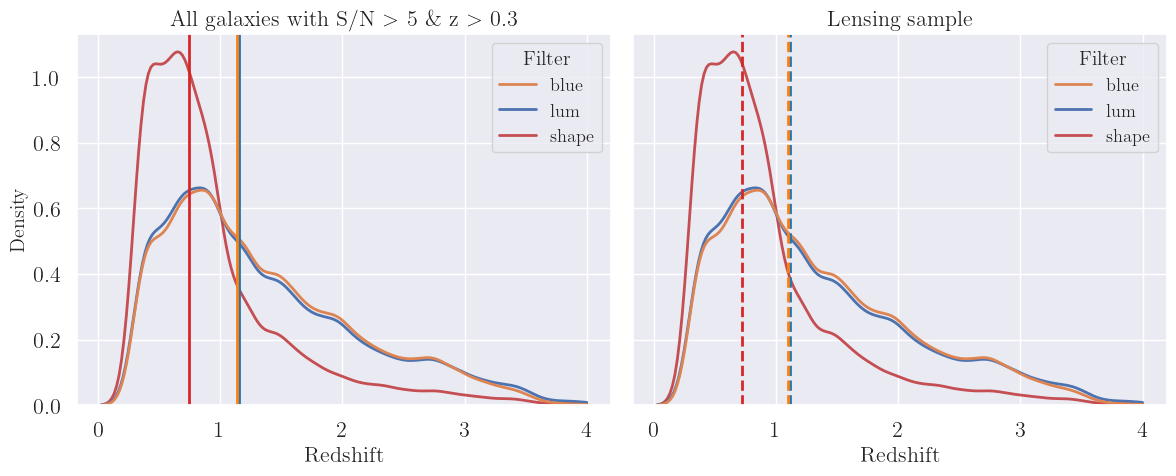

In [13]:

palette ={"C1", "C0", "C3"}

fig,ax = plt.subplots(1,2, tight_layout=True, figsize=(12,5), sharey=True)

'''
sns.histplot(joinedgals_pd, x='redshift', hue="Filter", element="step", bins=30, \
             stat="probability", common_norm=False, log_scale=[False, False], \
             binrange=[0,4], fill=True, ax=ax[0], palette=palette, \
             multiple="layer")

'''

sns.kdeplot(joinedgals_pd, x="redshift", hue="Filter", ax=ax[0], \
            multiple="layer", fill=False, palette=palette, clip=[0,4], \
            lw=2, common_norm=False, bw_adjust=1.5, \
            hue_order=["blue", "lum", "shape"])


ax[0].set_xlabel('Redshift', fontsize=16)
#ax[0].set_ylabel('Probability', fontsize=16)
ax[0].set_title('All galaxies with S/N $>$ 5 \& z $>$ 0.3', fontsize=16)

ax[0].axvline(np.median(all_gals_b[wgb]['redshift']), color='tab:blue', lw=2)
ax[0].axvline(np.median(all_gals_lum[wgl]['redshift']), color='tab:orange', lw=2)
ax[0].axvline(np.median(all_gals_shape[wgs]['redshift']), color='tab:red', lw=2)

'''
sns.histplot(sheargals_pd, x='redshift', hue="Filter", element="step", bins=30, \
             stat="probability", common_norm=False, log_scale=[False, False], \
             binrange=[0,4], fill=True, ax=ax[1], palette=palette, \
             multiple="layer")

'''
sns.kdeplot(joinedgals_pd, x="redshift", hue="Filter", ax=ax[1], \
            multiple="layer", fill=False, palette=palette, clip=[0,4], \
            lw=2, common_norm=False, bw_adjust=1.5, hue_order=["blue", "lum", "shape"])

ax[1].set_xlabel('Redshift', fontsize=16)
ax[1].set_title('Lensing sample', fontsize=16)

ax[1].axvline(np.median(shear_gals_b['redshift']), color='tab:blue', lw=2, linestyle='--')
ax[1].axvline(np.median(shear_gals_lum['redshift']), color='tab:orange', lw=2, linestyle='--')
ax[1].axvline(np.median(shear_gals_shape['redshift']), color='tab:red', lw=2, linestyle='--')

fig.savefig('cl_m4.1_z0.3_zhists.pdf')

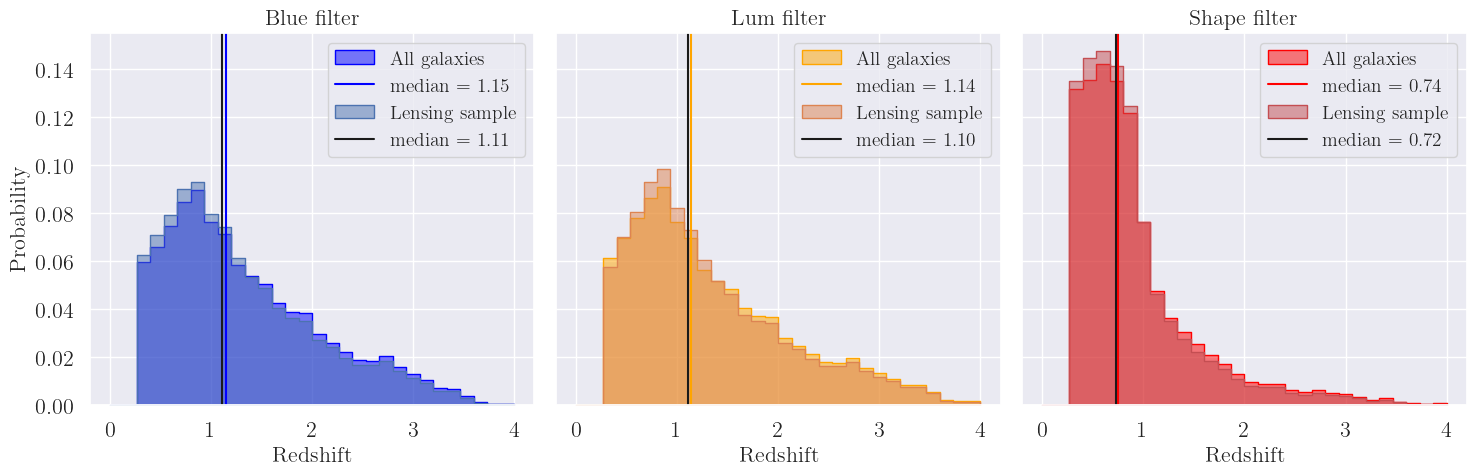

In [9]:
##
## Single band, with pre- and post-selection 
##

fig,ax = plt.subplots(1,3, tight_layout=True, figsize=(15,5), sharey=True)

###
### Blue 
###
sns.histplot(all_gals_b[wgb]['redshift'], element="step", bins=30, \
             stat="probability", common_norm=True, log_scale=[False, False], \
             binrange=[0,4], fill=True, ax=ax[0], color="blue", alpha=0.5, \
             multiple="layer", label='All galaxies')

ax[0].axvline(np.median(all_gals_b[wgb]['redshift']), color='blue', \
              label=f"median = {np.median(all_gals_b[wgb]['redshift']):1.2f}")

sns.histplot(shear_gals_b['redshift'], element="step", bins=30, \
             stat="probability", common_norm=True, log_scale=[False, False], \
             binrange=[0,4], fill=True, ax=ax[0], color="C0", alpha=0.5, \
             multiple="layer", label='Lensing sample')

ax[0].axvline(np.median(shear_gals_b['redshift']), color='k', \
              label=f"median = {np.median(shear_gals_b['redshift']):1.2f}")

ax[0].legend(fontsize=14)
ax[0].set_xlabel('Redshift', fontsize=16)
ax[0].set_ylabel('Probability', fontsize=16)
ax[0].set_title('Blue filter', fontsize=16)


###
### Lum
###

sns.histplot(all_gals_lum[wgl]['redshift'], element="step", bins=30, \
             stat="probability", common_norm=True, log_scale=[False, False], \
             binrange=[0,4], fill=True, ax=ax[1], color="orange", alpha=0.5, \
             multiple="layer", label='All galaxies')

ax[1].axvline(np.median(all_gals_lum[wgl]['redshift']), color='orange', \
              label=f"median = {np.median(all_gals_lum[wgl]['redshift']):1.2f}")

sns.histplot(shear_gals_lum['redshift'], element="step", bins=30, \
             stat="probability", common_norm=True, log_scale=[False, False], \
             binrange=[0,4], fill=True, ax=ax[1], color="C1", alpha=0.5, \
             multiple="layer", label='Lensing sample')

ax[1].axvline(np.median(shear_gals_lum['redshift']), color='k', \
              label=f"median = {np.median(shear_gals_lum['redshift']):1.2f}")

ax[1].legend(fontsize=14)
ax[1].set_xlabel('Redshift', fontsize=16)
ax[1].set_ylabel('Probability', fontsize=16)
ax[1].set_title('Lum filter', fontsize=16)


###
### Shape
###

sns.histplot(all_gals_shape[wgs]['redshift'], element="step", bins=30, \
             stat="probability", common_norm=True, log_scale=[False, False], \
             binrange=[0,4], fill=True, ax=ax[2], color="red", alpha=0.5, \
             multiple="layer", label='All galaxies')

ax[2].axvline(np.median(all_gals_shape[wgs]['redshift']), color='red', \
              label=f"median = {np.median(all_gals_shape[wgs]['redshift']):1.2f}")

sns.histplot(shear_gals_shape['redshift'], element="step", bins=30, \
             stat="probability", common_norm=True, log_scale=[False, False], \
             binrange=[0,4], fill=True, ax=ax[2], color="C3", alpha=0.5, \
             multiple="layer", label='Lensing sample')

ax[2].axvline(np.median(shear_gals_shape['redshift']), color='k', \
              label=f"median = {np.median(shear_gals_shape['redshift']):1.2f}")

ax[2].legend(fontsize=14)
ax[2].set_xlabel('Redshift', fontsize=16)
ax[2].set_ylabel('Probability', fontsize=16)
ax[2].set_title('Shape filter', fontsize=16)

fig.savefig('cl_m4.1_z0.3_indiv_zhists.pdf')

In [7]:
print(np.median(all_gals_b[wgb]['redshift']))
print(np.median(all_gals_lum[wgl]['redshift']))
print(np.median(all_gals_shape[wgs]['redshift']))

print('')
print(np.median(shear_gals_b['redshift']))
print(np.median(shear_gals_lum['redshift']))
print(np.median(shear_gals_shape['redshift']))


1.1523
1.1386
0.745

1.1113
1.1021
0.7244


## m4.1e14_z0.45

In [8]:
##
## Read in redshift distributions
## 
## all_gals_[filter]: everything that matched to truth
## selected_gals_[filter]: galaxies that passed all selection criteria
## 
 
path='/Users/j.mccleary/Research/SuperBIT/forecasting-analysis/paper_forecasting'

cluster_name = 'cl_m4.1e14_z0.45'

all_gals_name = os.path.join(path, '{cluster_name}_{forecast_name}_gals_joined_master_cat.fits')
selected_name = os.path.join(path, '{cluster_name}_{forecast_name}_annular_gals_master_cat.fits')

all_gals_b = Table.read(all_gals_name.format(cluster_name=cluster_name, forecast_name='forecast_blue'))
shear_gals_b = Table.read(selected_name.format(cluster_name=cluster_name, forecast_name='forecast_blue'))
all_gals_lum = Table.read(all_gals_name.format(cluster_name=cluster_name, forecast_name='forecast_lum'))
shear_gals_lum = Table.read(selected_name.format(cluster_name=cluster_name, forecast_name='forecast_lum'))
all_gals_shape = Table.read(all_gals_name.format(cluster_name=cluster_name, forecast_name='forecast_shape'))
shear_gals_shape = Table.read(selected_name.format(cluster_name=cluster_name, forecast_name='forecast_shape'))


cutoff = 5 
min_z = 0.45

wgb = (all_gals_b['snr_win'] > cutoff) & (all_gals_b['redshift'] > min_z)
wgs = (all_gals_shape['snr_win'] > cutoff) & (all_gals_shape['redshift'] > min_z)
wgl = (all_gals_lum['snr_win'] > cutoff) & (all_gals_lum['redshift'] > min_z)

all_gals_b.add_column('blue', name='Filter')
all_gals_lum.add_column('lum', name='Filter')
all_gals_shape.add_column('shape', name='Filter')

all_gals = vstack([all_gals_b[wgb], all_gals_lum[wgl], all_gals_shape[wgs]])

shear_gals_b.add_column('blue', name='Filter')
shear_gals_lum.add_column('lum', name='Filter')
shear_gals_shape.add_column('shape', name='Filter')

shear_gals = vstack([shear_gals_b, shear_gals_lum, shear_gals_shape])

sheargals_pd = shear_gals.to_pandas()
joinedgals_pd = all_gals.to_pandas()

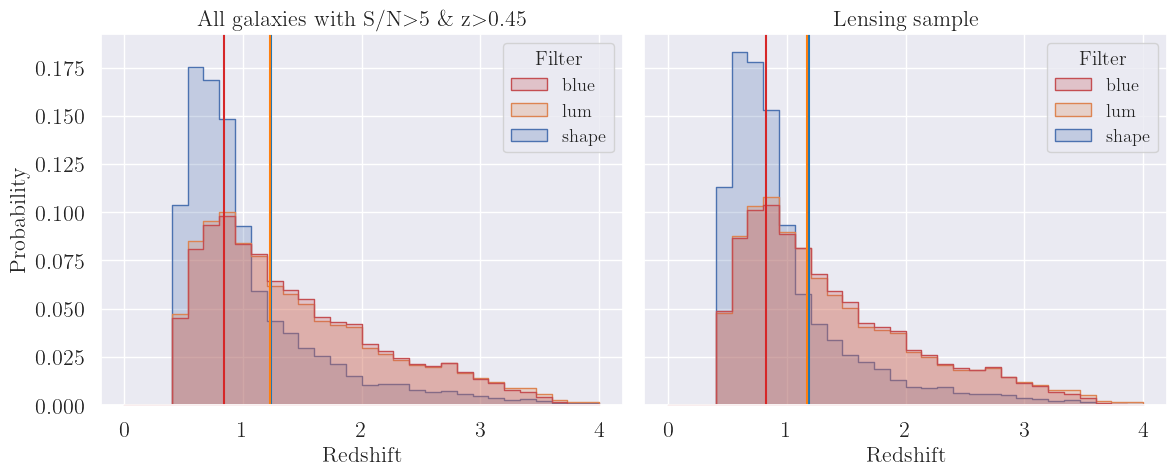

In [9]:
palette ={"C0", "C1", "C3"}

fig,ax = plt.subplots(1,2, tight_layout=True, figsize=(12,5), sharey=True)

sns.histplot(joinedgals_pd, x='redshift', hue="Filter", element="step", bins=30, \
             stat="probability", common_norm=False, log_scale=[False, False], \
             binrange=[0,4], fill=True, ax=ax[0], palette=palette, \
             multiple="layer")

ax[0].set_xlabel('Redshift', fontsize=16)
ax[0].set_ylabel('Probability', fontsize=16)
ax[0].set_title('All galaxies with S/N$>$5 \& z$>$0.45', fontsize=16)

ax[0].axvline(np.median(all_gals_b[wgb]['redshift']), color='tab:blue')
ax[0].axvline(np.median(all_gals_lum[wgl]['redshift']), color='tab:orange')
ax[0].axvline(np.median(all_gals_shape[wgs]['redshift']), color='tab:red')

sns.histplot(sheargals_pd, x='redshift', hue="Filter", element="step", bins=30, \
             stat="probability", common_norm=False, log_scale=[False, False], \
             binrange=[0,4], fill=True, ax=ax[1], palette=palette, \
             multiple="layer")

ax[1].set_xlabel('Redshift', fontsize=16)
ax[1].set_title('Lensing sample', fontsize=16)

ax[1].axvline(np.median(shear_gals_b['redshift']), color='tab:blue')
ax[1].axvline(np.median(shear_gals_lum['redshift']), color='tab:orange')
ax[1].axvline(np.median(shear_gals_shape['redshift']), color='tab:red')


fig.savefig('cl_m4.1_z0.45_zhists.pdf')

In [10]:
print(np.median(all_gals_b[wgb]['redshift']))
print(np.median(all_gals_lum[wgl]['redshift']))
print(np.median(all_gals_shape[wgs]['redshift']))

print('')
print(np.median(shear_gals_b['redshift']))
print(np.median(shear_gals_lum['redshift']))
print(np.median(shear_gals_shape['redshift']))


1.2367
1.2256
0.8412

1.1831
1.1709
0.8213


## m4.1e14_z0.059

In [11]:
path='/Users/j.mccleary/Research/SuperBIT/forecasting-analysis/paper_forecasting'

cluster_name = 'cl_m4.1e14_z0.059'

all_gals_name = os.path.join(path, '{cluster_name}_{forecast_name}_gals_joined_master_cat.fits')
selected_name = os.path.join(path, '{cluster_name}_{forecast_name}_annular_gals_master_cat.fits')

all_gals_b = Table.read(all_gals_name.format(cluster_name=cluster_name, forecast_name='forecast_blue'))
shear_gals_b = Table.read(selected_name.format(cluster_name=cluster_name, forecast_name='forecast_blue'))
all_gals_lum = Table.read(all_gals_name.format(cluster_name=cluster_name, forecast_name='forecast_lum'))
shear_gals_lum = Table.read(selected_name.format(cluster_name=cluster_name, forecast_name='forecast_lum'))
all_gals_shape = Table.read(all_gals_name.format(cluster_name=cluster_name, forecast_name='forecast_shape'))
shear_gals_shape = Table.read(selected_name.format(cluster_name=cluster_name, forecast_name='forecast_shape'))


cutoff = 5 
min_z = 0.059

wgb = (all_gals_b['snr_win'] > cutoff) & (all_gals_b['redshift'] > min_z)
wgs = (all_gals_shape['snr_win'] > cutoff) & (all_gals_shape['redshift'] > min_z)
wgl = (all_gals_lum['snr_win'] > cutoff) & (all_gals_lum['redshift'] > min_z)

all_gals_b.add_column('blue', name='Filter')
all_gals_lum.add_column('lum', name='Filter')
all_gals_shape.add_column('shape', name='Filter')

all_gals = vstack([all_gals_b[wgb], all_gals_lum[wgl], all_gals_shape[wgs]])

shear_gals_b.add_column('blue', name='Filter')
shear_gals_lum.add_column('lum', name='Filter')
shear_gals_shape.add_column('shape', name='Filter')

shear_gals = vstack([shear_gals_b, shear_gals_lum, shear_gals_shape])

sheargals_pd = shear_gals.to_pandas()
joinedgals_pd = all_gals.to_pandas()

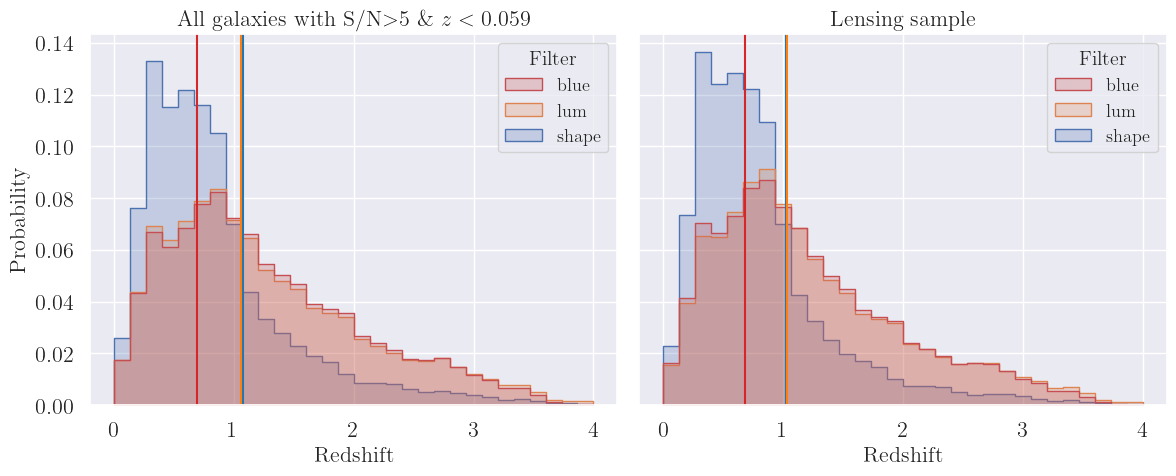

In [12]:
palette ={"C0", "C1", "C3"}

fig,ax = plt.subplots(1,2, tight_layout=True, figsize=(12,5), sharey=True)

sns.histplot(joinedgals_pd, x='redshift', hue="Filter", element="step", bins=30, \
             stat="probability", common_norm=False, log_scale=[False, False], \
             binrange=[0,4], fill=True, ax=ax[0], palette={"C3", "C1", "C0"}, \
             multiple="layer")

ax[0].set_xlabel('Redshift', fontsize=16)
ax[0].set_ylabel('Probability', fontsize=16)
ax[0].set_title('All galaxies with S/N$>$5 \& $z<0.059$', fontsize=16)

ax[0].axvline(np.median(all_gals_b['redshift']), color='tab:blue')
ax[0].axvline(np.median(all_gals_lum['redshift']), color='tab:orange')
ax[0].axvline(np.median(all_gals_shape['redshift']), color='tab:red')

sns.histplot(sheargals_pd, x='redshift', hue="Filter", element="step", bins=30, \
             stat="probability", common_norm=False, log_scale=[False, False], \
             binrange=[0,4], fill=True, ax=ax[1], palette=palette, \
             multiple="layer")

ax[1].set_xlabel('Redshift', fontsize=16)
ax[1].set_title('Lensing sample', fontsize=16)

ax[1].axvline(np.median(shear_gals_b['redshift']), color='tab:blue')
ax[1].axvline(np.median(shear_gals_lum['redshift']), color='tab:orange')
ax[1].axvline(np.median(shear_gals_shape['redshift']), color='tab:red')


fig.savefig('cl_m4.1_z0.059_zhists.pdf')

In [13]:
print(np.median(all_gals_b['redshift']))
print(np.median(all_gals_lum['redshift']))
print(np.median(all_gals_shape['redshift']))

print('')

print(np.median(shear_gals_b['redshift']))
print(np.median(shear_gals_lum['redshift']))
print(np.median(shear_gals_shape['redshift']))


1.0813
1.0622
0.691

1.02575
1.0295
0.6791


In [ ]:
        for band in bands:
            if band == 'u':
                palette['uv'] = 'magenta'
            elif (band == 'blue') or (band == 'b')
                palette['blue'] = 'C0'
            elif band == 'g':
                palette['g'] ='C2'
            elif band == 'lum':
                palette['lum'] = 'C1'
            elif band == 'shape':
                palette['shape'] = 'C3'
            else:
                raise KeyError(f'No palette color defined for band {band}')
        
